In [48]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from pandas import to_datetime
from matplotlib import pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
import seaborn as sns

In [115]:
#prepare the data

df = pd.read_csv('data/univariate/kenya/ken_u5_mortality.csv')
df.head(10)

,ds,y
0,1952-12-31,300.0374
1,1953-12-31,283.9339
2,1954-12-31,268.4150
3,1955-12-31,254.0990
4,1956-12-31,240.8236
5,1957-12-31,228.6289
6,1958-12-31,217.4429
7,1959-12-31,207.2148
8,1960-12-31,198.1244
9,1961-12-31,190.0339


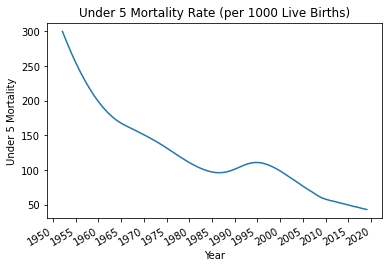

In [73]:
#visualize csv data
fig, ax = plt.subplots()
ax.plot(df['ds'],df['y'])

#transform the ticks (dates) ----- picked directly from matplotlib
# Major ticks every 6 months.
fmt_year = mdates.MonthLocator(interval = 60)
ax.xaxis.set_major_locator(fmt_year)

# Text in the x axis will be displayed in 'YYYY' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotates and right aligns the x labels, and moves the bottom of the axes up to make room for them.
fig.autofmt_xdate()
plt.xlabel('Year')
plt.ylabel('Under 5 Mortality')
plt.title('Under 5 Mortality Rate (per 1000 Live Births)')
plt.show()


In [75]:
#convert the dates to a datetimestring
df['ds']= to_datetime(df['ds'])

#define and fit the model
m= Prophet()
m.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:prophet:Making 10 forecasts with cutoffs between 1974-08-24 00:00:00 and 2018-12-31 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 16.
INFO:prophet:n_changepoints greater than number of observations. Using 20.
INFO:prophet:n_changepoints greater than number of observations. Using 24.


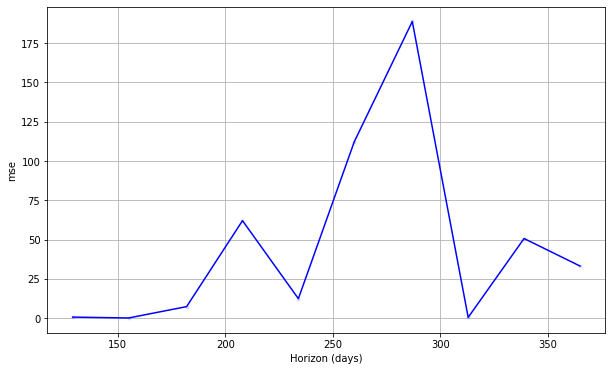

In [99]:
#check model perfomance using cross validation
#not sure how this works with little data

#create a custom cutoff date
cutoffs = pd.to_datetime(['1980-12-21','1990-12-21','2000-12-21'])

df_cv = cross_validation(m, initial='7300 days', period='1800 days', horizon = '365 days')

df_p = performance_metrics(df_cv)
df_p.head()

fig = plot_cross_validation_metric(df_cv, metric='mse')


In [113]:
#predict

#prepare the future dates
future = m.make_future_dataframe(freq = 'Y', periods=10)

forecast = m.predict(future)
forecast[['ds','yhat']].tail(10)

,ds,yhat
68,2020-12-31,37.405641
69,2021-12-31,34.794367
70,2022-12-31,32.345784
71,2023-12-31,30.057782
72,2024-12-31,27.631311
73,2025-12-31,25.020037
74,2026-12-31,22.571454
75,2027-12-31,20.283452
76,2028-12-31,17.856981
77,2029-12-31,15.245707


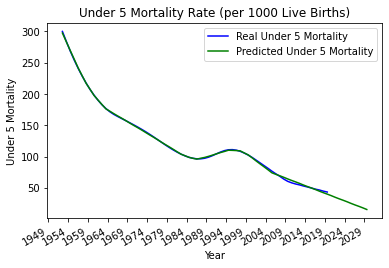

In [111]:
#visualize
# predicted = m.plot(forecast)

fig, ax = plt.subplots()
ax.plot(df['ds'],df['y'], color = 'blue', label = 'Real Under 5 Mortality')
ax.plot(forecast['ds'],forecast['yhat'], color = 'green', label = 'Predicted Under 5 Mortality')

# Major ticks every 6 months.
fmt_year = mdates.MonthLocator(interval = 60)
ax.xaxis.set_major_locator(fmt_year)

# Text in the x axis will be displayed in 'YYYY' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotates and right aligns the x labels, and moves the bottom of the axes up to make room for them.
fig.autofmt_xdate()
plt.xlabel('Year')
plt.legend()
plt.ylabel('Under 5 Mortality')
plt.title('Under 5 Mortality Rate (per 1000 Live Births)')
plt.show()